In [1]:
import sys
import sklearn
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

PROJECT_ROOT_DIR = "."

# MNIST

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

<function matplotlib.pyplot.show(close=None, block=None)>

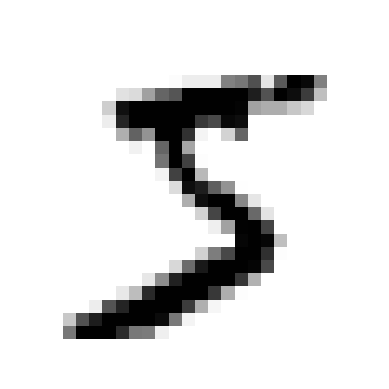

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show

In [6]:
y[0]

'5'

In [7]:
y = y.astype(np.uint8)

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [69]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate(
        [instances, np.zeros((n_empty, size * size))], axis=0
    )

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(
        n_rows * size, images_per_row * size
    )
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Treinando um Classificador Binário

In [10]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

# Cálculo de Desempenho

## Calculando a acurácia com a validação cruzada

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(
    sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy", verbose=2
)

[CV] END .................................................... total time=  15.8s
[CV] END .................................................... total time=  11.3s
[CV] END .................................................... total time=   7.9s


array([0.95035, 0.96035, 0.9604 ])

In [14]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()

cross_val_score(
    never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy", verbose=2
)

[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


array([0.91125, 0.90855, 0.90915])

## Matriz de confusão

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
y_train_perfect_prediction = y_train_5
confusion_matrix(y_train_5, y_train_perfect_prediction)

array([[54579,     0],
       [    0,  5421]])

## Precisão e revocação

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

np.float64(0.8370879772350012)

In [20]:
recall_score(y_train_5, y_train_pred)

np.float64(0.6511713705958311)

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

## Trade-off precisão/revocação

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000
y_some_digit_pred = y_scores > threshold
y_some_digit_pred

array([False])

In [25]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
f1 = 2 / ((1 / precisions[:-1]) + (1 / recalls[:-1]))

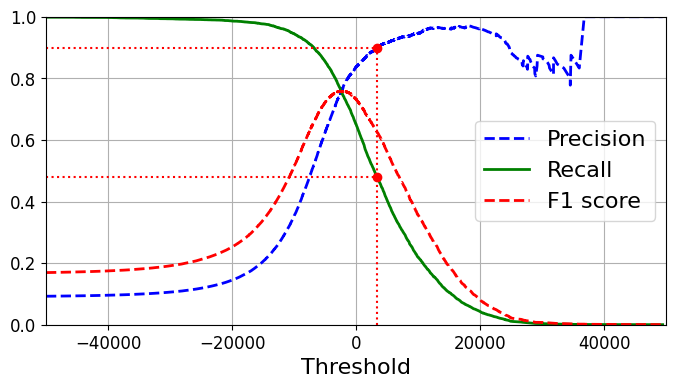

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, f1):
    plt.plot(
        thresholds, precisions[:-1], "b--", label="Precision", linewidth=2
    )
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.plot(thresholds, f1, "r--", label="F1 score", linewidth=2)
    plt.legend(loc="center right", fontsize=16)  # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)  # Not shown
    plt.grid(True)  # Not shown


recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, f1)
plt.plot(
    [threshold_90_precision, threshold_90_precision], [0.0, 0.9], "r:"
)  # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")  # Not shown
plt.plot(
    [-50000, threshold_90_precision],
    [recall_90_precision, recall_90_precision],
    "r:",
)  # Not shown
plt.plot([threshold_90_precision], [0.9], "ro")  # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")  # Not shown
plt.axis([-50000, 50000, 0, 1])  # Not shown
plt.show()

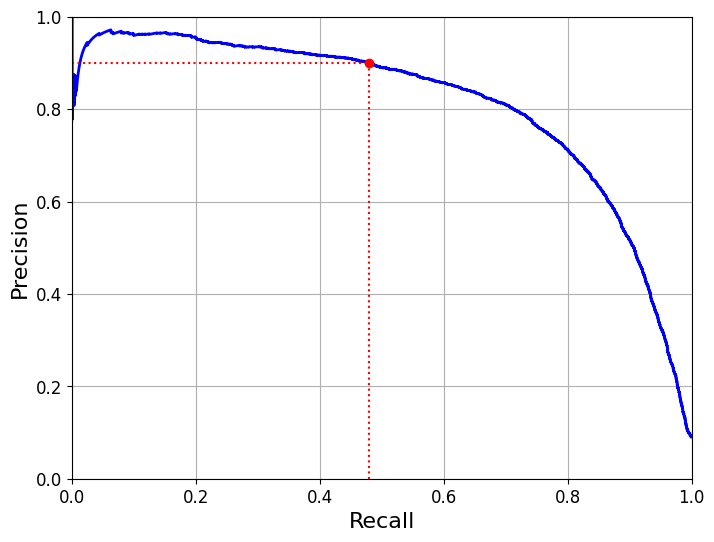

In [28]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)


plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0.0, 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

np.float64(3370.0194991439557)

In [30]:
y_train_pred_90 = y_scores >= threshold_90_precision

In [31]:
precision_score(y_train_5, y_train_pred_90)

np.float64(0.9000345901072293)

In [32]:
recall_score(y_train_5, y_train_pred_90)

np.float64(0.4799852425751706)

## A curva ROC

In [33]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

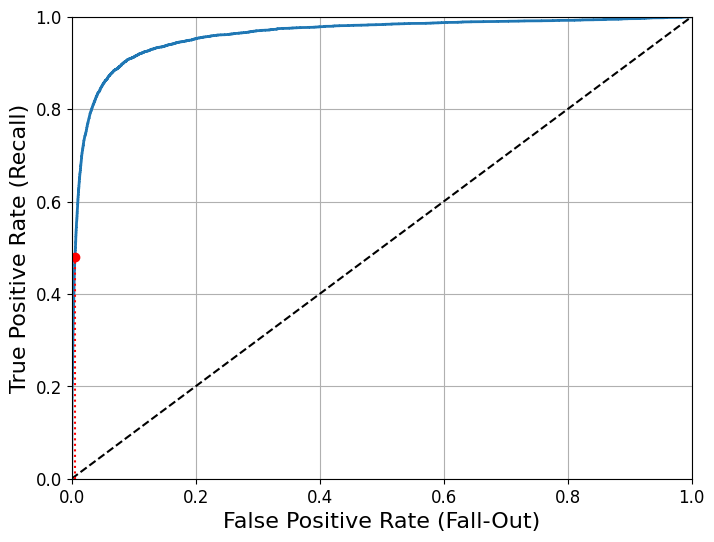

In [34]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")  # dashed diagonal
    plt.axis([0, 1, 0, 1])  # Not shown in the book
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)  # Not shown
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)  # Not shown
    plt.grid(True)  # Not shown


plt.figure(figsize=(8, 6))  # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]  # Not shown
plt.plot([fpr_90, fpr_90], [0.0, recall_90_precision], "r:")  # Not shown
plt.plot(
    [0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:"
)  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")  # Not shown
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_probas_forest = cross_val_predict(
    forest_clf,
    X_train,
    y_train_5,
    cv=3,
    method="predict_proba",
)

In [37]:
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, threshold_forest = roc_curve(
    y_train_5, y_scores_forest
)

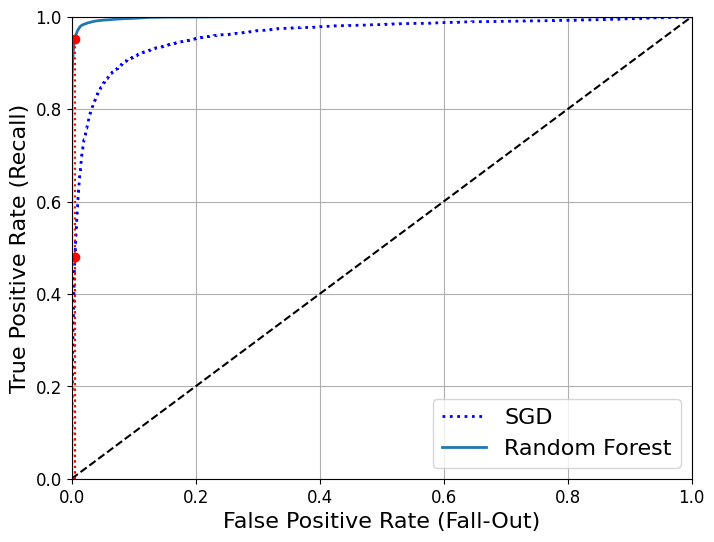

In [38]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0.0, recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0.0, recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [39]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [40]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest
)
f1_forest = 2 / ((1 / precisions_forest[:-1]) + (1 / recalls_forest[:-1]))

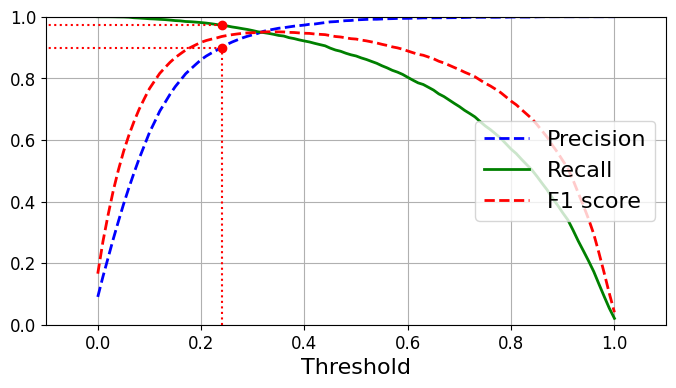

In [41]:
recall_90_precision_forest = recalls_forest[
    np.argmax(precisions_forest >= 0.90)
]
threshold_90_precision_forest = thresholds_forest[
    np.argmax(precisions_forest >= 0.90)
]


plt.figure(figsize=(8, 4))  # Not shown
plot_precision_recall_vs_threshold(
    precisions_forest, recalls_forest, thresholds_forest, f1_forest
)
plt.plot(
    [threshold_90_precision_forest, threshold_90_precision_forest],
    [0.0, 0.9],
    "r:",
)  # Not shown
plt.plot(
    [-50000, threshold_90_precision_forest], [0.9, 0.9], "r:"
)  # Not shown
plt.plot(
    [-50000, threshold_90_precision_forest],
    [recall_90_precision_forest, recall_90_precision_forest],
    "r:",
)  # Not shown
plt.plot([threshold_90_precision_forest], [0.9], "ro")  # Not shown
plt.plot(
    [threshold_90_precision_forest], [recall_90_precision_forest], "ro"
)  # Not shown
plt.axis([-0.1, 1.1, 0, 1])
plt.show()

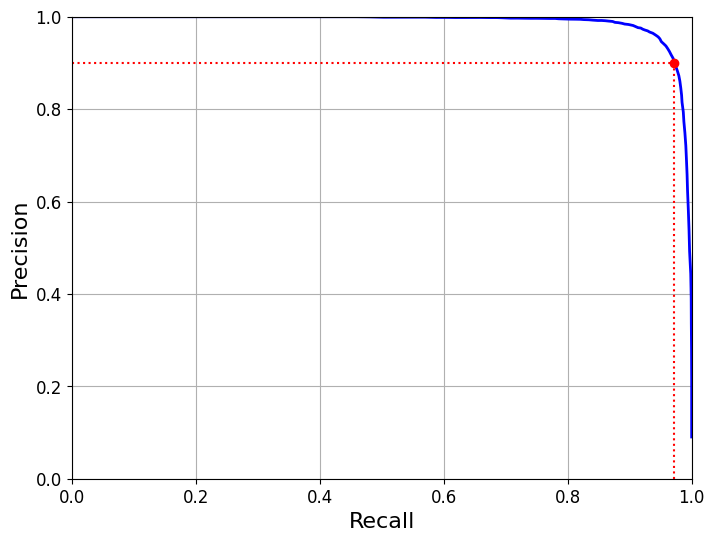

In [42]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions_forest, recalls_forest)
plt.plot(
    [recall_90_precision_forest, recall_90_precision_forest], [0.0, 0.9], "r:"
)
plt.plot([0.0, recall_90_precision_forest], [0.9, 0.9], "r:")
plt.plot([recall_90_precision_forest], [0.9], "ro")
plt.show()

# Classificação Multiclasse

In [43]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [45]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
ovr_clf.estimators_

[SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42),
 SVC(gamma='auto', random_state=42)]

In [47]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [48]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy", verbose=2)

[CV] END .................................................... total time= 2.1min
[CV] END .................................................... total time= 1.3min
[CV] END .................................................... total time= 1.3min


array([0.87365, 0.85835, 0.8689 ])

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(
    sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy", verbose=3
)

[CV] END ................................ score: (test=0.898) total time= 4.4min
[CV] END ................................ score: (test=0.891) total time= 3.9min
[CV] END ................................ score: (test=0.902) total time= 4.5min


array([0.8983, 0.891 , 0.9018])

# Análise de Erro

In [51]:
y_train_pred = cross_val_predict(
    sgd_clf, X_train_scaled, y_train, cv=3, verbose=3
)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

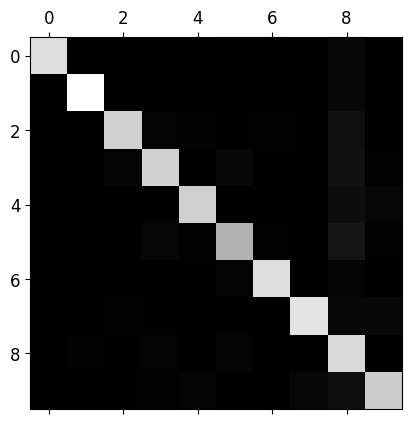

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [64]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

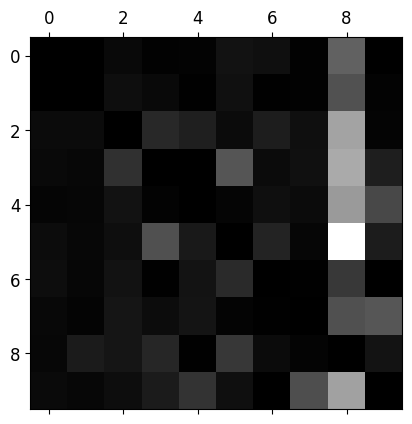

In [66]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

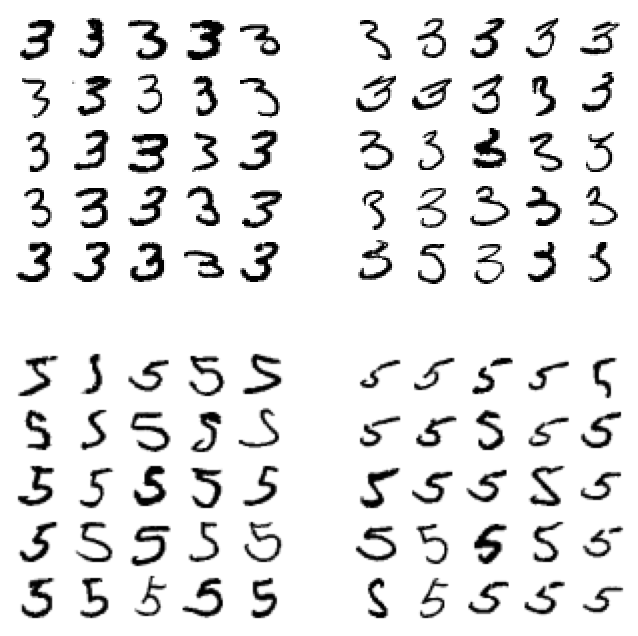

In [72]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Classificação Multirrótulo

In [73]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [74]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [75]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

np.float64(0.9764102655606048)

# Classificação Multioutput

In [77]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

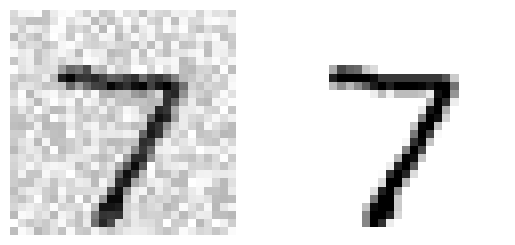

In [78]:
some_index = 0
plt.subplot(121)
plot_digit(X_test_mod[some_index])
plt.subplot(122)
plot_digit(y_test_mod[some_index])
plt.show()

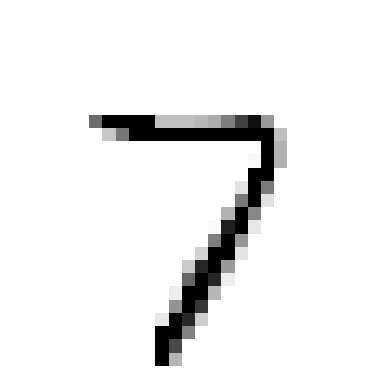

In [79]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)